## Dwarf galaxy discovery metric ##

In [1]:
import os
import numpy as np
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import MAF
import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

# Directly import the LVDwarfsMetrics module:
import sys
import importlib.util

spec_lv = importlib.util.spec_from_file_location('LVDwarfsMetrics', '/dlusers/jcarlin/repos/forks/rubin_sim/rubin_sim/maf/mafContrib/LVDwarfs/__init__.py')
LVmetrics = importlib.util.module_from_spec(spec_lv)
sys.modules['LVDwarfsMetrics'] = LVmetrics
spec_lv.loader.exec_module(LVmetrics)


### Methodology for Local Volume galaxies' dwarf satellites:
We use the latest tables from the [Local Volume Galaxies Database](http://www.sao.ru/lv/lvgdb/]) (based on Karachentsev et al. 2013), limiting our selection to Dec < 35 deg. We calculate the stellar mass of all galaxies using their total K−band luminosities, assuming mass-to-light of 1.0 in K. We then limit the sample to galaxies with $M_{star} > 10^7 M_{Sun}$ (removing the faintest systems, which will not be expected to have significant dwarf satellite populations; e.g., Dooley et al. 2017b,a); this leaves a total of 302 galaxies between 1.3 < D < 9 Mpc (of which 139 are within 6 Mpc).

The metric is evaluated at the positions of known galaxies by defining a custom `UserPointSlicer` object with the positions and distances to galaxies from the catalog described above. The function that creates this slicer is called `generateKnownLVDwarfSlicer`. (Note, however, that the metric can be calculated with a healpix map and a fixed distance limit; see below for more on this method.)

To estimate the detectability of dwarf satellites, we begin by considering the unresolved background galaxies and foreground Milky Way stars that contaminate a CMD selection of candidate RGB stars. For each of the galaxies in our sample, we extract the expected number of galaxies per square arcmin using the **GalaxyCountsMetric**, and the expected stellar density from the **StarDensityMetric**. We apply a scaling factor (`cmd_frac`=0.1 by default) to account for the sub-region of the CMD inhabited by our tracers (RGB stars) relative to the full-CMD area spanned by the simulations, and an additional scaling factor to account for unresolved galaxy contamination (`stargal_contamination`=0.4 by default) in a stellar sample selection at the faint end. Then, with an estimated number of contaminants, we calculate the number of stars required to be detected to reach a given Poisson-limited signal-to-noise (S/N > 10 by default). For the region around each Local Volume galaxy, we use a function called `makeFakeLF` which reads in a [PARSEC](http://stev.oapd.inaf.it/cgi-bin/cmd) luminosity function for an old (10 Gyr), metal-poor (\[M/H\] = −1.5) population and generates fake dwarf galaxies using a simulated luminosity function (in g and i bands). We generate dwarfs with known luminosities, continuing to fainter luminosities until we reach the S/N threshold. Our final figure of merit (FoM) is the number of Local Volume galaxies for which the faintest detectable dwarf satellite galaxy is fainter than our chosen dwarf luminosity threshold ($M_V = −7$).

In [3]:
opsim_fname = get_baseline()
print(opsim_fname)

runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)

/sims_maf/rubin_sim_data/sim_baseline/baseline_v2.0_10yrs.db
baseline_v2.0_10yrs


In [4]:
# Connect to the database so we can use it with MAF.
opsim_db = maf.OpsimDatabase(opsim_fname)

## Set up and run metric 1: number of host galaxies meeting required depth

In [5]:
# Create a slicer based on known galaxies within 9 Mpc, with stellar mass > 10^7 M_Sun:

# lv_slicer = maf.mafContrib.generateKnownLVDwarfSlicer()
lv_slicer = LVmetrics.generateKnownLVDwarfSlicer()

In [6]:
# Set up the metric
# mymetric = maf.mafContrib.LVDwarfsMetric() # for the discrete LV galaxies
# mymetric = maf.mafContrib.LVDwarfsMetric(distlim=0.05*u.Mpc) # for a distance limit, healpix map

mymetric = LVmetrics.LVDwarfsMetric() # for the discrete LV galaxies

In [7]:
# Define a sqlconstraint, if we need to just use a (large) subset of the opsim visits
# sqlconstraint = 'filter = "r"'
sqlconstraint = '(filter = "r" OR filter = "i" OR filter = "g")'
# sqlconstraint = None   # no constraint, make all visits available

In [8]:
# We already defined the slicer - combine the metric, slicer and sqlconstraint in a MetricBundle:
bundle = maf.MetricBundle(mymetric, lv_slicer, sqlconstraint, runName=runName)

In [9]:
# Pass the bundle (along with any other bundles to be run on this opsim) to a MetricBundleGroup in order to
# calculate the metric bundle values.
g = maf.MetricBundleGroup({'LVDwarfs_metric': bundle}, opsim_db, outDir='test', resultsDb=None)
# And calculate the metric
g.runAll()

Querying database observations with constraint (filter = "r" OR filter = "i" OR filter = "g") for columns ['fieldDec', 'rotSkyPos', 'fiveSigmaDepth', 'fieldRA', 'filter']
Found 1156352 visits
Running:  ['LVDwarfs_metric']


/dlusers/jcarlin/repos/forks/rubin_sim/rubin_sim/maf/mafContrib/LVDwarfs/LVDwarfsMetrics.py:113: RuntimeWarning: divide by zero encountered in log10
  mtot = magref-2.5*np.log10(totlum)
/dlusers/jcarlin/repos/forks/rubin_sim/rubin_sim/maf/mafContrib/LVDwarfs/LVDwarfsMetrics.py:329: RuntimeWarning: invalid value encountered in double_scalars
  mv = mg_lim - 0.371 * (mg_lim - mi_lim) - 0.068
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/metrics/simpleMetrics.py:42: RuntimeWarning: divide by zero encountered in log10
  return 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.colname])))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### Calculate the metric

The Local Volume dwarf satellites metric is simply the number of hosts to which we meet a given dwarf detection threshold. We choose a threshold of $M_V < -5.5$ (which corresponds to stellar mass of about $2\times10^4 M_{\rm Sun}$), and report the total number (out of 302 input galaxies) that reach this threshold.

In [10]:
mv_threshold = -5.5
ok_mv = (bundle.metricValues.data > mv_threshold) & (bundle.metricValues.mask == False)
print('Number (out of 302) of galaxies surveyed to the requested depth: ', np.sum(ok_mv))

Number (out of 302) of galaxies surveyed to the requested depth:  205


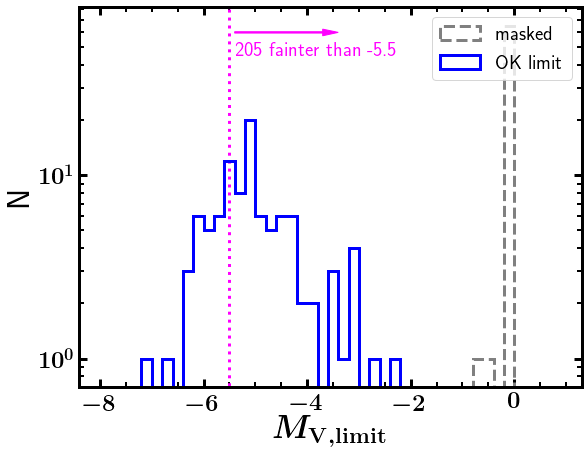

In [11]:
params = {
   'axes.labelsize': 32,
   'font.size': 24,
   'legend.fontsize': 20,
#   'xtick.labelsize': 16,
   'xtick.major.width': 3,
   'xtick.minor.width': 2,
   'xtick.major.size': 8,
   'xtick.minor.size': 5,
   'xtick.direction': 'in',
   'xtick.top': True,
   'lines.linewidth':3,
   'axes.linewidth':3,
   'axes.labelweight':3,
   'axes.titleweight':3,
   'ytick.major.width':3,
   'ytick.minor.width':2,
   'ytick.major.size': 8,
   'ytick.minor.size': 5,
   'ytick.direction': 'in',
   'ytick.right': True,
#   'ytick.labelsize': 20,
   'text.usetex': True,
   'text.latex.preamble': r'\boldmath',
   'figure.figsize': [9, 7],
   'figure.facecolor': 'White'
    }

plt.rcParams.update(params)

plt.hist(bundle.metricValues.data, bins=np.arange(-8, 4, 0.2), log=True, histtype='step', color='Gray', label='masked',
         linewidth=3, linestyle='--')
plt.hist(bundle.metricValues.data[bundle.metricValues.mask == False], bins=np.arange(-8, 4, 0.2), log=True, histtype='step',
         color='Blue', label='OK limit', linewidth=3)
plt.vlines(-5.5, 0, 200, color='magenta', linestyle=':', linewidth=3)
plt.arrow(-5.4, 60.0, 2, 0, color='magenta', width=1, length_includes_head=True, head_width=5, head_length=0.3)
plt.text(-5.4, 45, str(np.sum(ok_mv))+' fainter than -5.5', color='magenta', fontsize='small')
plt.ylim(0.7, 83)
plt.xlim(-8.4, 1.3)
plt.legend()
plt.xlabel(r'$M_{\rm V, limit}$')
plt.ylabel('N')
plt.minorticks_on()
plt.show()

### Metric 2: total sky area within 4 Mpc that meets the required depth

The second Local Volume dwarf satellites metric is total sky area at which the survey meets a given dwarf detection threshold at some distance. We choose a threshold of $M_V < -5.5$ (which corresponds to stellar mass of about $2\times10^4 M_{\rm Sun}$), and report the total sky area to which we reach this threshold.

In [12]:
mymetric2 = LVmetrics.LVDwarfsMetric(distlim=4.0*u.Mpc) # for a distance limit, healpix map
healpix_slicer = maf.HealpixSlicer(nside=16)
bundle2 = maf.MetricBundle(mymetric2, healpix_slicer, sqlconstraint, runName=runName)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes


In [13]:
g2 = maf.MetricBundleGroup({'LVDwarfs_area_metric': bundle2}, opsim_db, outDir='test', resultsDb=None)
g2.runAll()

Querying database observations with constraint (filter = "r" OR filter = "i" OR filter = "g") for columns ['fieldDec', 'rotSkyPos', 'fiveSigmaDepth', 'fieldRA', 'filter']
Found 1156352 visits
Running:  ['LVDwarfs_area_metric']


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/slicers/baseSpatialSlicer.py:103: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/maps/dustMap.py:25: UserWarning: Slicer value of nside 16 different from map value 128, using slicer value
  warnings.warn(f"Slicer value of nside {slicePoints['nside']} different "
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/metrics/simpleMetrics.py:42: RuntimeWarning: divide by zero encountered in log10
  return 1.25 * np.log10(np.sum(10.**(.8*dataSlice[self.colname])))
/dlusers/jcarlin/repos/forks/rubin_sim/rubin_sim/maf/mafContrib/LVDwarfs/LVDwarfsMetrics.py:113: RuntimeWarning: divide by zero encountered in log10
  mtot = magref-2.5*np.log10(totlum)
/dlusers/jcarlin/repos/forks/rubin_sim/rubin_sim/maf/mafContrib/LVDwarfs/LVDwarfsMetrics.py:329: RuntimeWarning: invalid value enco

Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


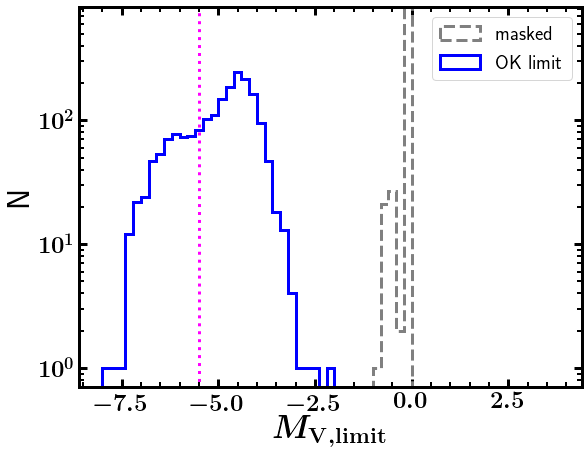

In [14]:
plt.hist(bundle2.metricValues.data, bins=np.arange(-8, 4, 0.2), log=True, histtype='step', color='Gray', label='masked',
         linewidth=3, linestyle='--')
plt.hist(bundle2.metricValues.data[bundle2.metricValues.mask == False], bins=np.arange(-8, 4, 0.2), log=True, histtype='step',
         color='Blue', label='OK limit', linewidth=3)
plt.vlines(-5.5, 0, 1000, color='magenta', linestyle=':', linewidth=3)
plt.ylim(0.7, 830)
#plt.xlim(-9.3, 1.8)
plt.legend()
plt.xlabel(r'$M_{\rm V, limit}$')
plt.ylabel('N')
plt.minorticks_on()
plt.show()

In [15]:
summary_area = maf.AreaThresholdMetric(lower_threshold=-5.5)
bundle2.setSummaryMetrics([summary_area])
bundle2.computeSummaryStats()
bundle2.summaryValues

{'AreaThreshold': 21539.632110699386}

### Metric 3: detection limits for Milky Way dwarfs in the south Galactic cap

In [16]:
sql_scp = '(filter = "r" OR filter = "i" OR filter = "g") and fieldDec < -60'

In [17]:
mymetric3 = LVmetrics.LVDwarfsMetric(distlim=0.1*u.Mpc) # for a distance limit, healpix map
healpix_slicer3 = maf.HealpixSlicer(nside=32)
bundle3 = maf.MetricBundle(mymetric3, healpix_slicer3, sql_scp, runName=runName)

Healpix slicer using NSIDE=32, approximate resolution 109.935565 arcminutes


In [18]:
g3 = maf.MetricBundleGroup({'LVDwarfs_SCP_metric': bundle3}, opsim_db, outDir='test', resultsDb=None)
g3.runAll()

Querying database observations with constraint (filter = "r" OR filter = "i" OR filter = "g") and fieldDec < -60 for columns ['fieldDec', 'rotSkyPos', 'fiveSigmaDepth', 'fieldRA', 'filter']
Found 85778 visits
Running:  ['LVDwarfs_SCP_metric']


/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/slicers/baseSpatialSlicer.py:103: UserWarning: Warning:  Loading maps but cache on.Should probably set useCache=False in slicer.
  warnings.warn('Warning:  Loading maps but cache on.'
/data0/sw/lsst_stack-2021.10.13/rubin_sim/rubin_sim/maf/maps/dustMap.py:25: UserWarning: Slicer value of nside 32 different from map value 128, using slicer value
  warnings.warn(f"Slicer value of nside {slicePoints['nside']} different "


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


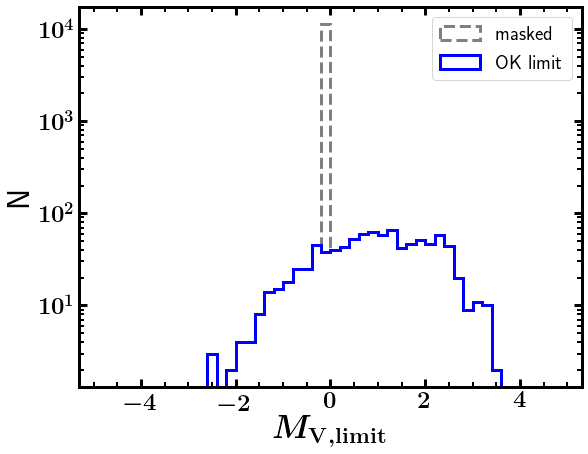

In [19]:
plt.hist(bundle3.metricValues.data, bins=np.arange(-8, 4, 0.2), log=True, histtype='step', color='Gray', label='masked',
         linewidth=3, linestyle='--')
plt.hist(bundle3.metricValues.data[bundle3.metricValues.mask == False], bins=np.arange(-8, 4, 0.2), log=True, histtype='step',
         color='Blue', label='OK limit', linewidth=3)
# plt.ylim(0.7, 830)
plt.xlim(-5.3, 5.3)
plt.legend()
plt.xlabel(r'$M_{\rm V, limit}$')
plt.ylabel('N')
plt.minorticks_on()
plt.show()

In [20]:
### Do we want to maximize the area below some limiting M_V, or maximize the median, limiting M_V, etc?

In [21]:
summary_area = maf.AreaThresholdMetric(lower_threshold=0.0)
summary_median = maf.MedianMetric()
bundle3.setSummaryMetrics([summary_area, summary_median])
bundle3.computeSummaryStats()
bundle3.summaryValues

{'AreaThreshold': 2427.237221950694, 'Median': 1.010430567516378}